In [50]:
import cv2
import mediapipe as mp
import numpy as np
import os
from pathlib import Path


## Extracting Landmarks From Dataset

In [51]:
def extract_landmarks_from_video(video_path):
    mp_pose = mp.solutions.pose
    pose = mp_pose.Pose(static_image_mode=False)
    
    cap = cv2.VideoCapture(video_path)
    landmarks_all_frames = []

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        # Convert frame to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        result = pose.process(frame_rgb)

        if result.pose_landmarks:
            # Extract (x, y, z) for 33 landmarks
            landmarks = []
            for lm in result.pose_landmarks.landmark:
                landmarks.extend([lm.x, lm.y, lm.z])
            landmarks_all_frames.append(landmarks)

    cap.release()
    pose.close()

    if landmarks_all_frames:
        return np.array(landmarks_all_frames)  # shape: (num_frames, 99)
    else:
        return None


In [52]:
def process_dataset_split(split_dir, label_map, output_dir="landmark_data"):
    Path(output_dir).mkdir(exist_ok=True)

    for class_name, label in label_map.items():
        class_path = os.path.join(split_dir, class_name)
        for video_file in os.listdir(class_path):
            if not video_file.endswith(".mp4"):
                continue

            video_path = os.path.join(class_path, video_file)
            landmarks = extract_landmarks_from_video(video_path)

            if landmarks is not None:
                output_filename = f"{split_dir.split('/')[-1]}_{class_name.replace(' ', '_')}_{video_file.replace('.mp4', '')}.npy"
                np.save(os.path.join(output_dir, output_filename), {
                    "landmarks": landmarks,
                    "label": label
                })


## Testing Landmarks Drawing

In [53]:
import cv2
import mediapipe as mp

# Initialize MediaPipe pose and drawing utils
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils

# Load your video
video_path = "split_dataset/train/Arm Raise Correct/13.mp4"
cap = cv2.VideoCapture(video_path)

# Initialize pose estimator
with mp_pose.Pose(static_image_mode=False) as pose:
    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        # Convert frame to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Get pose landmarks
        result = pose.process(frame_rgb)

        # Draw the pose landmarks if detected
        if result.pose_landmarks:
            # Draw points and skeleton on original frame
            mp_drawing.draw_landmarks(
                frame,                         # frame to draw on
                result.pose_landmarks,         # detected landmarks
                mp_pose.POSE_CONNECTIONS       # predefined connections between keypoints
            )

        # Show the frame
        cv2.imshow('Pose Visualization', frame)

        # Exit on pressing 'q'
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

# Cleanup
cap.release()
cv2.destroyAllWindows()


In [54]:
label_map = {
    "Arm Raise Correct": 1,
    "Arm Raise Incorrect": 0
}

process_dataset_split("split_dataset/train", label_map)
process_dataset_split("split_dataset/val", label_map)
process_dataset_split("split_dataset/test", label_map)


In [55]:
import numpy as np
import os

# Paths
data_dir = "landmark_data"
X_train, y_train = [], []
X_val, y_val = [], []
X_test, y_test = [], []

# Loop over all .npy files
for file in os.listdir(data_dir):
    if not file.endswith(".npy"):
        continue

    data = np.load(os.path.join(data_dir, file), allow_pickle=True).item()
    landmarks = data['landmarks']    # shape: (num_frames, 99)
    label = data['label']            # 0 or 1

    # Convert to fixed size vector: average over frames → shape (99,)
    feature_vector = np.mean(landmarks, axis=0)

    # Decide which split it belongs to (based on filename prefix)
    if file.startswith("train"):
        X_train.append(feature_vector)
        y_train.append(label)
    elif file.startswith("val"):
        X_val.append(feature_vector)
        y_val.append(label)
    elif file.startswith("test"):
        X_test.append(feature_vector)
        y_test.append(label)

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

# Print shapes
print("Train:", X_train.shape, y_train.shape)
print("Val:", X_val.shape, y_val.shape)
print("Test:", X_test.shape, y_test.shape)


Train: (97, 99) (97,)
Val: (31, 99) (31,)
Test: (33, 99) (33,)


## Model Training And Performance Evaluation

Train Labels Count: [48 49]
Val Labels Count: [15 16]
Test Labels Count: [17 16]

Validation Accuracy: 0.9354838709677419

Validation Confusion Matrix:
[[14  1]
 [ 1 15]]

Classification Report (Validation):
              precision    recall  f1-score   support

   Incorrect       0.93      0.93      0.93        15
     Correct       0.94      0.94      0.94        16

    accuracy                           0.94        31
   macro avg       0.94      0.94      0.94        31
weighted avg       0.94      0.94      0.94        31


Test Accuracy: 0.9393939393939394

Test Confusion Matrix:
[[17  0]
 [ 2 14]]

Classification Report (Test):
              precision    recall  f1-score   support

   Incorrect       0.89      1.00      0.94        17
     Correct       1.00      0.88      0.93        16

    accuracy                           0.94        33
   macro avg       0.95      0.94      0.94        33
weighted avg       0.95      0.94      0.94        33



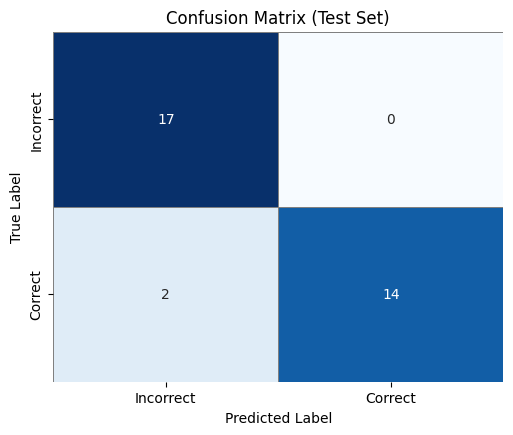


Predictions vs Actual (Test Set):
Sample 1: Predicted = 1, Actual = 1
Sample 2: Predicted = 1, Actual = 1
Sample 3: Predicted = 1, Actual = 1
Sample 4: Predicted = 1, Actual = 1
Sample 5: Predicted = 1, Actual = 1
Sample 6: Predicted = 1, Actual = 1
Sample 7: Predicted = 1, Actual = 1
Sample 8: Predicted = 1, Actual = 1
Sample 9: Predicted = 1, Actual = 1
Sample 10: Predicted = 1, Actual = 1
Sample 11: Predicted = 1, Actual = 1
Sample 12: Predicted = 1, Actual = 1
Sample 13: Predicted = 1, Actual = 1
Sample 14: Predicted = 1, Actual = 1
Sample 15: Predicted = 0, Actual = 1
Sample 16: Predicted = 0, Actual = 1
Sample 17: Predicted = 0, Actual = 0
Sample 18: Predicted = 0, Actual = 0
Sample 19: Predicted = 0, Actual = 0
Sample 20: Predicted = 0, Actual = 0
Sample 21: Predicted = 0, Actual = 0
Sample 22: Predicted = 0, Actual = 0
Sample 23: Predicted = 0, Actual = 0
Sample 24: Predicted = 0, Actual = 0
Sample 25: Predicted = 0, Actual = 0
Sample 26: Predicted = 0, Actual = 0
Sample 27: P

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import joblib  # For saving the model

# Define class names
class_names = ["Incorrect", "Correct"]

# Print label distribution
print("Train Labels Count:", np.bincount(y_train))
print("Val Labels Count:", np.bincount(y_val))
print("Test Labels Count:", np.bincount(y_test))

# Initialize the model with tuned parameters
model = RandomForestClassifier(
    n_estimators=50,     # Fewer trees
    max_depth=3,         # Limit depth to reduce overfitting
    random_state=42
)

# Train the model
model.fit(X_train, y_train)


# Validation Evaluation

val_preds = model.predict(X_val)
val_acc = accuracy_score(y_val, val_preds)
print("\nValidation Accuracy:", val_acc)

print("\nValidation Confusion Matrix:")
val_cm = confusion_matrix(y_val, val_preds)
print(val_cm)

print("\nClassification Report (Validation):")
print(classification_report(y_val, val_preds, target_names=class_names))


# Test Evaluation

test_preds = model.predict(X_test)
test_acc = accuracy_score(y_test, test_preds)
print("\nTest Accuracy:", test_acc)

print("\nTest Confusion Matrix:")
test_cm = confusion_matrix(y_test, test_preds)
print(test_cm)

print("\nClassification Report (Test):")
print(classification_report(y_test, test_preds, target_names=class_names))


# Plot Confusion Matrix (Test Set)

plt.figure(figsize=(6, 5))
ax = sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues',
                 xticklabels=class_names, yticklabels=class_names,
                 cbar=False, linewidths=0.5, linecolor='gray')

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Test Set)")
plt.subplots_adjust(left=0.2, right=0.95, top=0.9, bottom=0.2)  
plt.show()


# Show predictions vs actual

print("\nPredictions vs Actual (Test Set):")
for i, (p, a) in enumerate(zip(test_preds, y_test)):
    print(f"Sample {i + 1}: Predicted = {p}, Actual = {a}")


# Save the trained model

joblib.dump(model, "posture_model.pkl")
print("\nModel saved as 'posture_model.pkl'")


## Real-Time Pose Classification

In [66]:
import cv2
import mediapipe as mp
import numpy as np
import joblib
import csv
import os
from datetime import datetime

# Load the trained model 
model = joblib.load("posture_model.pkl")
print("✅ Model loaded successfully")

# Initialize MediaPipe Pose 
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils
pose = mp_pose.Pose(static_image_mode=False)

# Initialize webcam
cap = cv2.VideoCapture(0)

# Log file setup
log_file = "prediction_log.csv"
if not os.path.exists(log_file):
    with open(log_file, mode='w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Timestamp", "Prediction"])

last_logged_label = None  # to avoid logging the same label repeatedly

while cap.isOpened():
    success, frame = cap.read()
    if not success:
        break

    # Flip for mirror view
    frame = cv2.flip(frame, 1)

    # Convert frame to RGB
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    result = pose.process(frame_rgb)

    label_text = "No pose detected"

    if result.pose_landmarks:
        landmarks = []
        for lm in result.pose_landmarks.landmark:
            landmarks.extend([lm.x, lm.y, lm.z])

        if len(landmarks) == 99:
            # Convert to array and predict
            features = np.array(landmarks).reshape(1, -1)
            prediction = model.predict(features)[0]
            label_text = "Correct" if prediction == 1 else "Incorrect"

            # Log prediction with timestamp if it's different from last one
            if label_text != last_logged_label:
                with open(log_file, mode='a', newline='') as f:
                    writer = csv.writer(f)
                    writer.writerow([datetime.now().isoformat(), label_text])
                last_logged_label = label_text

        # Draw pose skeleton
        mp_drawing.draw_landmarks(
            frame,
            result.pose_landmarks,
            mp_pose.POSE_CONNECTIONS
        )

    # Display label on screen
    cv2.putText(
        frame, label_text, (10, 40),
        cv2.FONT_HERSHEY_SIMPLEX, 1.2,
        (0, 255, 0) if label_text == "Correct" else (0, 0, 255),
        3
    )

    # Show the webcam feed
    cv2.imshow("Posture Classification", frame)

    # Press 'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Cleanup
cap.release()
cv2.destroyAllWindows()
pose.close()


✅ Model loaded successfully


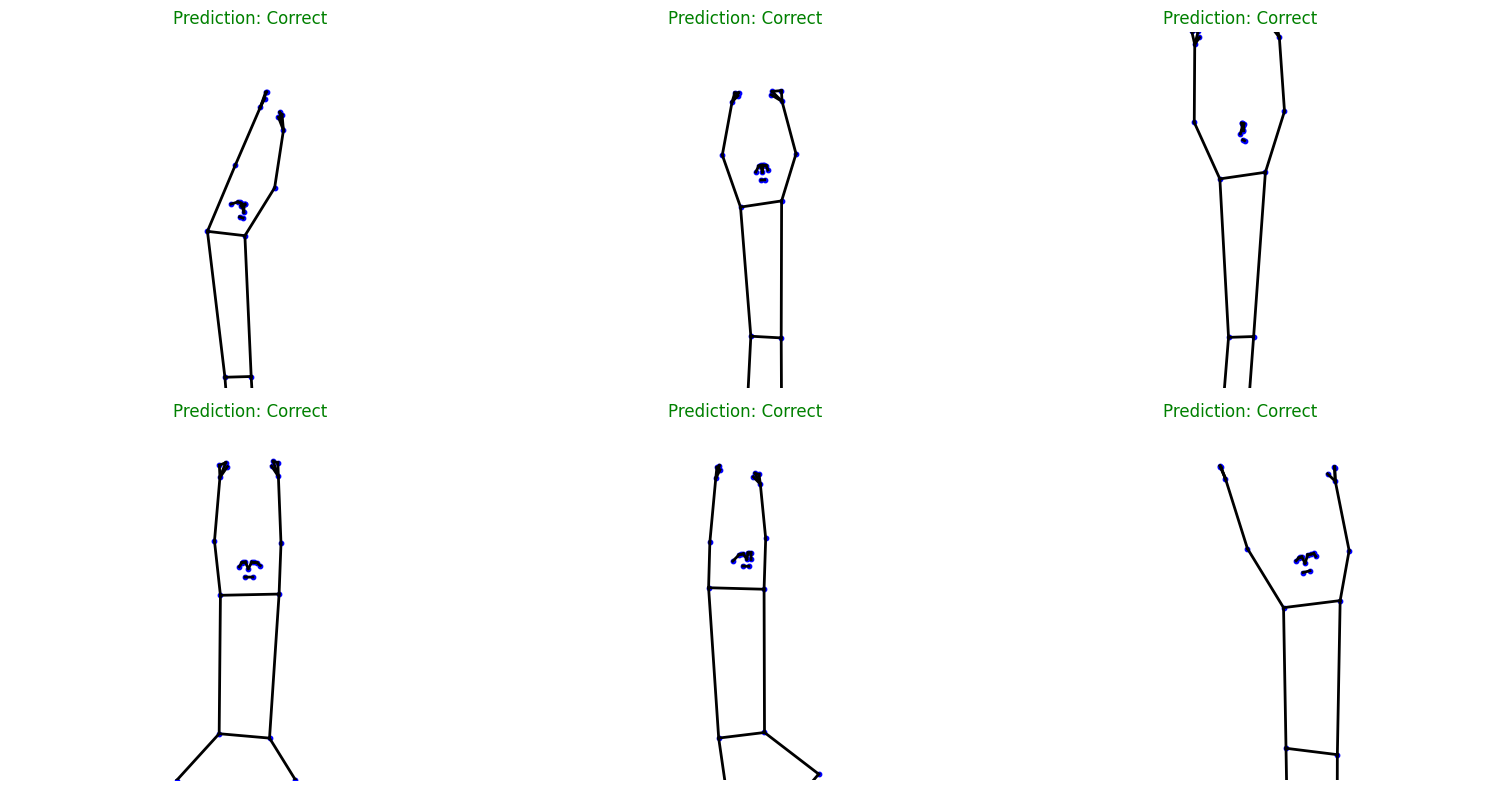

In [64]:
import numpy as np
import os
import matplotlib.pyplot as plt
import mediapipe as mp

# MediaPipe landmark layout
mp_pose = mp.solutions.pose
POSE_CONNECTIONS = mp_pose.POSE_CONNECTIONS
LANDMARK_NAMES = mp_pose.PoseLandmark

# Load and plot landmarks
def plot_pose(landmarks, label_text, ax):
    # Create a white image
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)
    ax.axis('off')

    # Reshape to (33, 3)
    points = landmarks.reshape(-1, 3)

    # Draw connections
    for connection in POSE_CONNECTIONS:
        start_idx, end_idx = connection
        x1, y1 = points[start_idx][:2]
        x2, y2 = points[end_idx][:2]
        ax.plot([x1, x2], [y1, y2], color='black', linewidth=2)

    # Draw joints
    ax.scatter(points[:, 0], points[:, 1], c='blue', s=10)

    # Add label
    ax.set_title(f"Prediction: {label_text}", fontsize=12, color='green' if label_text == "Correct" else 'red')

# Folder containing .npy test files
folder = "landmark_data"
n_plots = 6  # how many test samples to visualize

# Collect test files only
test_files = [f for f in os.listdir(folder) if f.startswith("test") and f.endswith(".npy")]

# Plot some test examples
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, file in enumerate(test_files[:n_plots]):
    data = np.load(os.path.join(folder, file), allow_pickle=True).item()
    label = data['label']
    landmarks = data['landmarks']

    # Take the middle frame for visualization
    frame = landmarks[len(landmarks) // 2]

    label_text = "Correct" if label == 1 else "Incorrect"
    plot_pose(frame, label_text, axes[i])

plt.tight_layout()
plt.show()
